# House Prices Advanced Regression Techniques 4

From part 3, we saw that CatBoostRegressor perform worse when we selected top 20 important features. We guess that using all feature might be the good idea.

So in this part, we will re-train all models from part 1 but using all features.

## Baseline

We use model from P3 as baseline. Taking all columns, default parameters, and no feature engineering.

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OrdinalEncoder, FunctionTransformer
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer, TransformedTargetRegressor

from catboost import CatBoostRegressor

In [2]:
continuous_pip = make_pipeline(
    SimpleImputer(strategy="median"),
    StandardScaler()
)

discrete_pipe = make_pipeline(
    SimpleImputer(strategy="most_frequent"),
    OrdinalEncoder()
)

preprocess_pipe = make_column_transformer(
    (continuous_pip, make_column_selector(dtype_include=np.number)),
    (discrete_pipe, make_column_selector(dtype_include=object))
)

cat_boost_regressor = CatBoostRegressor(random_state=42, silent=True, allow_writing_files=False)
log_level_regressor = TransformedTargetRegressor(
    cat_boost_regressor,
    func=np.log1p,
    inverse_func=np.expm1,
)

cat_boost_pipe_base_line = make_pipeline(
    preprocess_pipe,
    log_level_regressor
)

In [3]:
df_train = pd.read_csv("../input/house-prices-advanced-regression-techniques/train.csv")

df_preprocess = preprocess_pipe.fit_transform(df_train.drop(columns=["Id", "SalePrice"]))
df_target = np.log1p(df_train["SalePrice"])

baseline_score = cross_val_score(cat_boost_regressor, df_preprocess, df_target, cv=5, scoring="neg_root_mean_squared_error")
print(f"Baseline score: {baseline_score.mean():.3f} +/- {baseline_score.std():.3f}")

Baseline score: -0.121 +/- 0.012


## Try with models from part 1

We are not sure if the old params might be the best params in this case. So we will try to find the best params for each model again.

In [4]:
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Lasso, Ridge, HuberRegressor
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor, \
    VotingRegressor, StackingRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.kernel_ridge import KernelRidge
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

import warnings

warnings.filterwarnings("ignore")

In [5]:
lasso = Lasso(random_state=0)
lasso_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1],
}

lasso_cv = GridSearchCV(
    lasso,
    param_grid=lasso_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

lasso_cv.fit(df_preprocess, df_target)

print(f'Best score: {lasso_cv.best_score_}')
print(f'Best params: {lasso_cv.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score: -0.14973831225052195
Best params: {'alpha': 0.001}


In [6]:
ridge = Ridge(random_state=0)
ridge_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1],
}

ridge_cv = GridSearchCV(
    ridge,
    param_grid=ridge_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

ridge_cv.fit(df_preprocess, df_target)

print(f'Best score: {ridge_cv.best_score_}')
print(f'Best params: {ridge_cv.best_params_}')

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best score: -0.15138814469791143
Best params: {'alpha': 1}


In [7]:
huber = HuberRegressor()
huber_param_grid = {
    'alpha': [0.0001, 0.001, 0.01, 1],
    'epsilon': [1.35, 1.5, 1.75],
    'max_iter': [300, 500, 1000],
}

huber_cv = GridSearchCV(
    huber,
    param_grid=huber_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

huber_cv.fit(df_preprocess, df_target)

print(f'Best score: {huber_cv.best_score_}')
print(f'Best params: {huber_cv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -0.2564849589080319
Best params: {'alpha': 1, 'epsilon': 1.75, 'max_iter': 1000}


In [8]:
ada = AdaBoostRegressor(random_state=0)
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}

ada_cv = GridSearchCV(
    ada,
    param_grid=ada_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

ada_cv.fit(df_preprocess, df_target)

print(f'Best score: {ada_cv.best_score_}')
print(f'Best params: {ada_cv.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: -0.17166928836861067
Best params: {'learning_rate': 1, 'n_estimators': 100}


In [9]:
random_forest = RandomForestRegressor(random_state=0)
random_forest_param_grid = {
    'n_estimators': [100, 120, 150],
    'max_depth': [10, 13, 15],
}

random_forest_cv = GridSearchCV(
    random_forest,
    param_grid=random_forest_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

random_forest_cv.fit(df_preprocess, df_target)

print(f'Best score: {random_forest_cv.best_score_}')
print(f'Best params: {random_forest_cv.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: -0.1423629250558255
Best params: {'max_depth': 13, 'n_estimators': 120}


In [10]:
extra_tree = ExtraTreesRegressor(random_state=0)

extra_tree_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 13, 15],
}

extra_tree_cv = GridSearchCV(
    extra_tree,
    param_grid=extra_tree_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

extra_tree_cv.fit(df_preprocess, df_target)

print(f'Best score: {extra_tree_cv.best_score_}')
print(f'Best params: {extra_tree_cv.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: -0.13568872292054307
Best params: {'max_depth': 15, 'n_estimators': 200}


In [11]:
gradient_boosting = GradientBoostingRegressor(random_state=0)

gradient_boosting_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}

gradient_boosting_cv = GridSearchCV(
    gradient_boosting,
    param_grid=gradient_boosting_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

gradient_boosting_cv.fit(df_preprocess, df_target)

print(f'Best score: {gradient_boosting_cv.best_score_}')
print(f'Best params: {gradient_boosting_cv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -0.12740450188983787
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [12]:
svr = SVR()

svr_param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.001, 0.1, 1],
}

svr_cv = GridSearchCV(
    svr,
    param_grid=svr_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

svr_cv.fit(df_preprocess, df_target)

print(f'Best score: {svr_cv.best_score_}')
print(f'Best params: {svr_cv.best_params_}')

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best score: -0.12602725164245793
Best params: {'C': 1, 'epsilon': 0.001}


In [13]:
decision_tree = DecisionTreeRegressor(random_state=0)

decision_tree_param_grid = {
    'max_depth': [5, 10, 15, 20, 25, 30, 35, 40, 45],
}

decision_tree_cv = GridSearchCV(
    decision_tree,
    param_grid=decision_tree_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

decision_tree_cv.fit(df_preprocess, df_target)

print(f'Best score: {decision_tree_cv.best_score_}')
print(f'Best params: {decision_tree_cv.best_params_}')


Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best score: -0.1999469732998809
Best params: {'max_depth': 20}


In [14]:
k_neighbors = KNeighborsRegressor()

k_neighbors_param_grid = {
    'n_neighbors': [5, 7, 9, 11, 13, 15],
}

k_neighbors_cv = GridSearchCV(
    k_neighbors,
    param_grid=k_neighbors_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

k_neighbors_cv.fit(df_preprocess, df_target)

print(f'Best score: {k_neighbors_cv.best_score_}')
print(f'Best params: {k_neighbors_cv.best_params_}')

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best score: -0.19456383085078313
Best params: {'n_neighbors': 9}


In [15]:
kernel_ridge = KernelRidge()

kernel_ridge_param_grid = {
    'alpha': [0.0001, 0.001, 0.1, 1],
    'gamma': [0.0001, 0.001, 0.1, 1],
}

kernel_ridge_cv = GridSearchCV(
    kernel_ridge,
    param_grid=kernel_ridge_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

kernel_ridge_cv.fit(df_preprocess, df_target)

print(f'Best score: {kernel_ridge_cv.best_score_}')
print(f'Best params: {kernel_ridge_cv.best_params_}')

Fitting 5 folds for each of 16 candidates, totalling 80 fits
Best score: -0.3145973361599249
Best params: {'alpha': 1, 'gamma': 0.0001}


In [16]:
xgboost = XGBRegressor(random_state=0)

xgboost_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}

xgboost_cv = GridSearchCV(
    xgboost,
    param_grid=xgboost_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

xgboost_cv.fit(df_preprocess, df_target)

print(f'Best score: {xgboost_cv.best_score_}')
print(f'Best params: {xgboost_cv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -0.1307707939832206
Best params: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [17]:
lightgbm = LGBMRegressor(random_state=0)

lightgbm_param_grid = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 15],
    'learning_rate': [0.001, 0.01, 0.1, 1],
}

lightgbm_cv = GridSearchCV(
    lightgbm,
    param_grid=lightgbm_param_grid,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

lightgbm_cv.fit(df_preprocess, df_target)

print(f'Best score: {lightgbm_cv.best_score_}')
print(f'Best params: {lightgbm_cv.best_params_}')

Fitting 5 folds for each of 36 candidates, totalling 180 fits
Best score: -0.13197748682935997
Best params: {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 150}


Plotting the results

<Axes: xlabel='Score', ylabel='Model'>

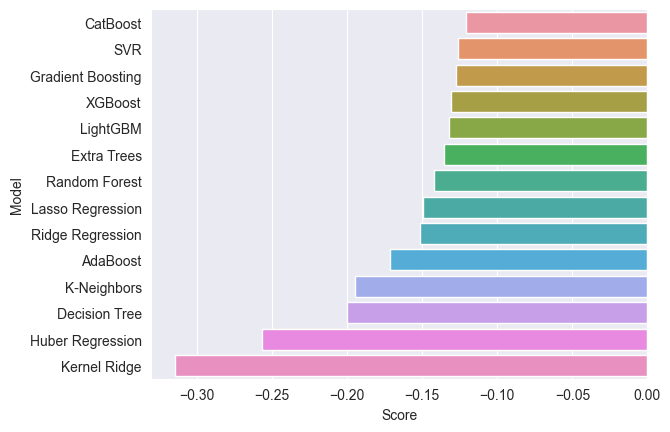

In [18]:
df_score = pd.DataFrame({
    'Model': [
        'Ridge Regression',
        'Lasso Regression',
        'Huber Regression',
        'AdaBoost',
        'Random Forest',
        'Extra Trees',
        'Gradient Boosting',
        'SVR',
        'Decision Tree',
        'K-Neighbors',
        'Kernel Ridge',
        'XGBoost',
        'LightGBM',
        'CatBoost'
    ],
    'Score': [
        ridge_cv.best_score_,
        lasso_cv.best_score_,
        huber_cv.best_score_,
        ada_cv.best_score_,
        random_forest_cv.best_score_,
        extra_tree_cv.best_score_,
        gradient_boosting_cv.best_score_,
        svr_cv.best_score_,
        decision_tree_cv.best_score_,
        k_neighbors_cv.best_score_,
        kernel_ridge_cv.best_score_,
        xgboost_cv.best_score_,
        lightgbm_cv.best_score_,
        baseline_score.mean()
    ]
})

sns.barplot(x='Score', y='Model', data=df_score.sort_values(by='Score', ascending=False))

The ranking change a lot. We will pick top 5 to put them into VotingRegressor and StackingRegressor.

In [27]:
voting_regressor = VotingRegressor(
    estimators=[
        ('cat_boost', cat_boost_regressor),
        ('svr', svr_cv.best_estimator_),
        ('gradient_boosting', gradient_boosting_cv.best_estimator_),
        ('xgboost', xgboost_cv.best_estimator_),
        ('lightgbm', lightgbm_cv.best_estimator_),
    ],
    n_jobs=-1,
    verbose=1
)

voting_regressor.fit(df_preprocess, df_target)

voting_regressor_score = cross_val_score(
    voting_regressor,
    df_preprocess,
    df_target,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print(f'Voting Regressor score: {voting_regressor_score.mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Voting Regressor score: -0.11971840215663292


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    6.7s finished


In [28]:
stacking_regressor = StackingRegressor(
    estimators=[
        ('cat_boost', cat_boost_regressor),
        ('svr', svr_cv.best_estimator_),
        ('gradient_boosting', gradient_boosting_cv.best_estimator_),
        ('xgboost', xgboost_cv.best_estimator_),
        ('lightgbm', lightgbm_cv.best_estimator_),
    ],
    final_estimator=Ridge(),
    n_jobs=-1,
    verbose=1
)

stacking_regressor.fit(df_preprocess, df_target)

stacking_regressor_score = cross_val_score(
    stacking_regressor,
    df_preprocess,
    df_target,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print(f'Stacking Regressor score: {stacking_regressor_score.mean()}')

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Stacking Regressor score: -0.11804825390443521


[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   45.3s finished


<Axes: xlabel='Score', ylabel='Model'>

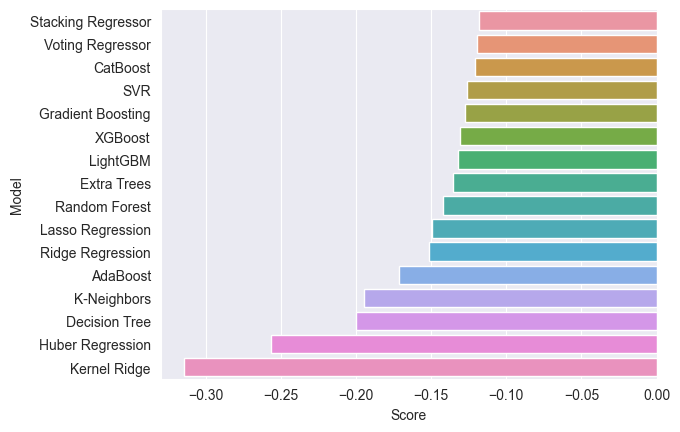

In [29]:
df_score2 = pd.DataFrame({
    'Model': [
        'Voting Regressor',
        'Stacking Regressor',
    ],
    'Score': [
        voting_regressor_score.mean(),
        stacking_regressor_score.mean(),
    ]
})

sns.barplot(
    x='Score',
    y='Model',
    data=pd.concat([df_score, df_score2], axis=0).sort_values(by='Score', ascending=False)
)

Let's make predictions with the new VotingRegressor and StackingRegressor.

In [22]:
def round_nearest_50(sale_price: pd.Series) ->  pd.Series:
    return (sale_price / 50).round() * 50

In [30]:
voting_pipe = make_pipeline(
    preprocess_pipe,
    TransformedTargetRegressor(
        regressor=voting_regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
)

df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
voting_pipe.fit(df_train.drop(columns=["Id", "SalePrice"]), df_train['SalePrice'])

df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_test['SalePrice'] = voting_pipe.predict(df_test.drop(columns=["Id"]))

df_test['Id'] = df_test['Id'].astype(int)
df_test[['Id', 'SalePrice']].to_csv('../input/house-prices-advanced-regression-techniques/submission/voting-regression-v6.2.csv', index=False)

In [31]:
df_test['SalePrice'] = round_nearest_50(df_test['SalePrice'])
df_test[['Id', 'SalePrice']].to_csv('../input/house-prices-advanced-regression-techniques/submission/voting-regression-v6.3.csv', index=False)

Score: 0.12293

In [34]:
stacking_pipe = make_pipeline(
    preprocess_pipe,
    TransformedTargetRegressor(
        regressor=stacking_regressor,
        func=np.log1p,
        inverse_func=np.expm1
    )
)

df_train = pd.read_csv('../input/house-prices-advanced-regression-techniques/train.csv')
stacking_pipe.fit(df_train.drop(columns=["Id", "SalePrice"]), df_train['SalePrice'])

df_test = pd.read_csv('../input/house-prices-advanced-regression-techniques/test.csv')
df_test['SalePrice'] = stacking_pipe.predict(df_test.drop(columns=["Id"]))

df_test['Id'] = df_test['Id'].astype(int)
df_test[['Id', 'SalePrice']].to_csv('../input/house-prices-advanced-regression-techniques/submission/stack-regression-v3.2.csv', index=False)

In [35]:
df_test['SalePrice'] = round_nearest_50(df_test['SalePrice'])
df_test[['Id', 'SalePrice']].to_csv('../input/house-prices-advanced-regression-techniques/submission/stack-regression-v3.3.csv', index=False)

Score: 0.12226